<a href="https://colab.research.google.com/github/beyzaslan/HackerRank_Projects/blob/main/MNIST_Uygulama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kütüphanlerin Yüklenmesi**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# GPU kullanımını kontrol et
print("TensorFlow GPU destekli: ", tf.config.list_physical_devices('GPU'))

TensorFlow GPU destekli:  []


**Veri Setinin Yüklenmesi**

In [3]:
import tensorflow as tf

# MNIST veri setini yükle
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Veriyi normalize et (-1 ile 1 arasına ölçekle)
x_train = (x_train - 127.5) / 127.5  # Değerler [-1, 1] aralığında olacak şekilde normalleştir
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  # Görsellerin boyutunu (28, 28, 1) yap
x_train = x_train[:20000]  # Daha fazla veri (İlk 20.000 örnek)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Veri Setinin Boyutu**

*   60.000 adet 28x28 boyutunda, gri tonlu görüntüden oluşmaktadır.




In [4]:
print(f"x_train şekli: {x_train.shape}")


x_train şekli: (20000, 28, 28, 1)


**Eğitim veri setinden bir kesit**

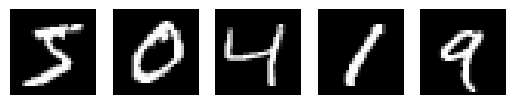

In [5]:
import matplotlib.pyplot as plt

# İlk 5 görüntüyü görselleştir
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')  # Tek kanal (grayscale)
    plt.axis('off')
plt.show()


**GAN Mimarisi**

**Generator (Üretici Model)**

In [6]:
#Gürültüyü gerçekçi bir görüntüye dönüştüren model:

def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=100),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(28 * 28 * 1, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model


**Discriminator (Ayrımcı Model)**

In [7]:
# Discriminator Modeli
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
    return model


**Generator ve Discriminator’u birleştiren GAN:**

In [8]:
# GAN Modeli
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Discriminator sadece ayrı ayrı eğitilecek
    model = tf.keras.Sequential([generator, discriminator])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    return model


**Eğitim Döngüsü**

In [ ]:
# Modelleri oluşturun
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Eğitim parametreleri
epochs = 10000  # Epoch sayısını artırın
batch_size = 64  # Batch boyutunu artırın
half_batch = batch_size // 2

# Eğitim döngüsü
for epoch in range(epochs):
    # Gerçek verilerden örnek alın
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_images = x_train[idx]

    # Sahte görüntüler üretin
    noise = np.random.normal(0, 1, (half_batch, 100))  # Gürültü boyutu 100
    fake_images = generator.predict(noise)

    # Discriminator’u eğitin
    real_y = np.ones((half_batch, 1))
    fake_y = np.zeros((half_batch, 1))
    d_loss_real = discriminator.train_on_batch(real_images, real_y)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_y)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Generator’u eğitin
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.ones((batch_size, 1))  # Generator sahteyi gerçek göstermeye çalışacak
    g_loss = gan.train_on_batch(noise, valid_y)

    # Her 500 epoch'ta bir çıktı alın
    if epoch % 500 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | acc.: {100*d_loss[1]:.2f}] [G loss: {g_loss}]")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7067487835884094 | acc.: 58.59] [G loss: [array(0.702441, dtype=float32), array(0.702441, dtype=float32), array(0.578125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

**Görsellerin Üretilmesi ve Görüntüleme**


In [ ]:
# Görselleri üretin ve görüntüleyin
def generate_and_plot_images(generator, num_images=10):
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Görüntüyü normalize et

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

# Üretilmiş görselleri görüntüleyin
generate_and_plot_images(generator)

